In [214]:
import pandas
import matplotlib
import matplotlib.pyplot as plt
import seaborn 
import gzip
import lifelines

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

In [178]:
with gzip.GzipFile('../data/exports_cran.csv.gz') as f:
    exports = pandas.read_csv(f, usecols=['repository', 'ref', 'export'])
with gzip.GzipFile('../data/index_cran.csv.gz') as f: 
    packages = pandas.read_csv(f, parse_dates=['time'], usecols=['source', 'repository', 'ref', 'time'])

In [179]:
exports = exports.rename(columns={'repository': 'package', 'ref': 'version', 'export': 'item'})
packages = packages.query('source == "cran"').rename(columns={'repository': 'package', 'ref': 'version'})

In [180]:
packages = (packages
    .groupby(by='package')
    .time
    .agg({'pkg_firstdate': pandas.np.min, 'pkg_lastdate': pandas.np.max})
    .merge(packages, how='left', left_index=True, right_on='package')
    .drop('source', axis=1)
)

exports = exports.merge(packages[['package', 'version', 'time']], on=('package', 'version')).sort_values('time')

**Drop RGtk2 because it's an outlier...**

In [181]:
outliers = ['RGtk2']
for package in outliers: 
    packages = packages.query('package != "{}"'.format(package))
    exports = exports.query('package != "{}"'.format(package))

In [182]:
by_item = {}
by_version = {}

for package, package_group in exports.groupby('package'):
    created_date = package_group.time.min()
    last_items = set()
        
    for time, time_group in package_group.groupby('time'):        
        items = set(time_group.item)    
        additions = items.difference(last_items)
        deletions = last_items.difference(items)
        last_items = set(items)

        for item in additions:
            by_item.setdefault((package, item), {})
            
            by_item[(package, item)]['added_in'] = time
            by_item[(package, item)]['added_after'] = time - created_date
        for item in deletions:
            by_item[(package, item)]['deleted_in'] = time
            by_item[(package, item)]['deleted_after'] = time - created_date
    
        by_version[(package, time_group['version'].iloc[0])] = {'items': len(items), 
                                          'additions': len(additions), 
                                          'deletions': len(deletions)}

In [183]:
df_by_item = pandas.DataFrame.from_dict(by_item, orient='index')
df_by_item = df_by_item.rename_axis(['package', 'version'])

df_by_version = pandas.DataFrame.from_dict(by_version, orient='index')
df_by_version = df_by_version.rename_axis(['package', 'version'])

# Overview

## Packages and versions

In [184]:
print(len(packages.groupby('package')), 'distinct packages')
print(len(packages.groupby(('package', 'version'))), 'versions')
print('Since {} to {} ({})'
      .format(packages.time.min(), packages.time.max(), packages.time.max() - packages.time.min()))

9567 distinct packages
57475 versions
Since 1997-10-08 19:56:17 to 2016-04-26 20:52:26 (6775 days 00:56:09)


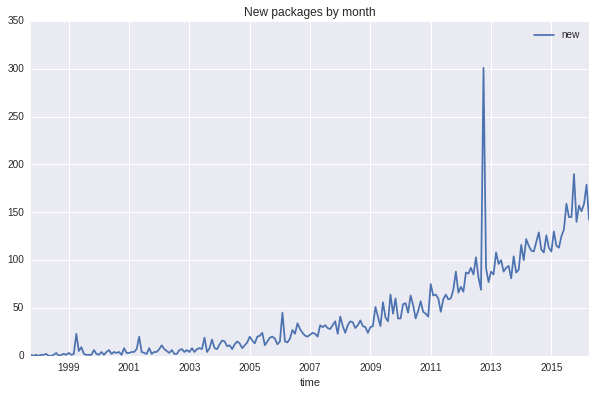

In [185]:
df = packages.groupby('package')[['time']].min().sort_values('time').assign(new=1)
df = df.set_index('time').resample('1M')
ax = df.count().plot(title='New packages by month')

## Items

In [186]:
print(len(exports.groupby(('package', 'item'))), 'uniquely identified exported items')
print(len(exports.groupby(('package', 'item', 'version'))), 'exported items')

227599 uniquely identified exported items
1637143 exported items


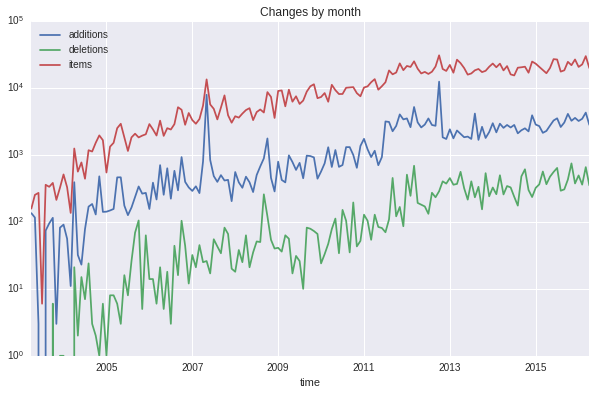

In [187]:
df = df_by_version.merge(packages[['time', 'package', 'version']], left_index=True, right_on=('package', 'version'))
ax = df.set_index('time')[['additions', 'deletions', 'items']].resample('1M').sum().plot(logy=True, title='Changes by month')

# API changes

## Changes distribution by packages and by versions

(0, 60)

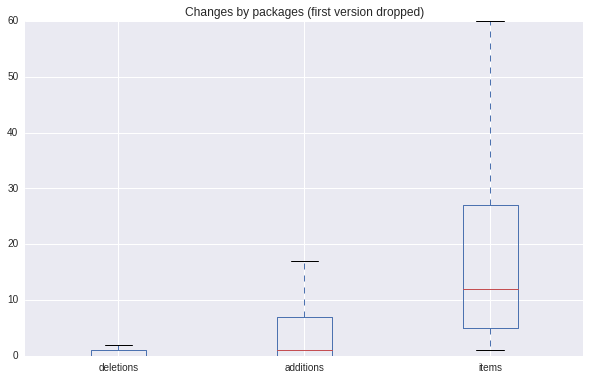

In [188]:
ax = (df_by_version
  .query('additions != items')
  .groupby(level=[0])
  .agg({'items': pandas.np.max, 'additions': pandas.np.sum, 'deletions': pandas.np.sum})
  .plot.box(title='Changes by packages (first version dropped)'))
ax.set_ylim(0, 60)

(0, 10)

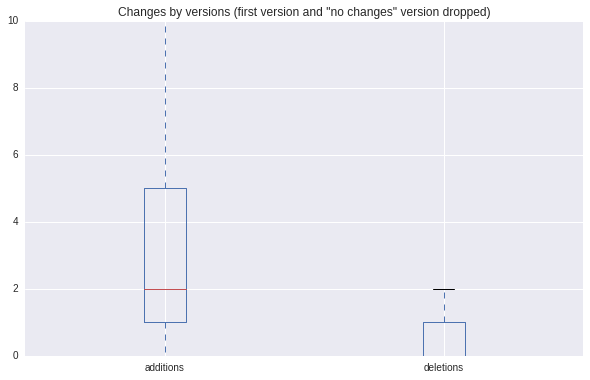

In [189]:
ax = (df_by_version
  .query('additions != items and (additions > 0 or deletions > 0)')
  .groupby(level=[0, 1])
  .agg({'additions': pandas.np.sum, 'deletions': pandas.np.sum})
  .plot.box(title='Changes by versions (first version and "no changes" version dropped)'))
ax.set_ylim(0, 10)

##  Changes by dates

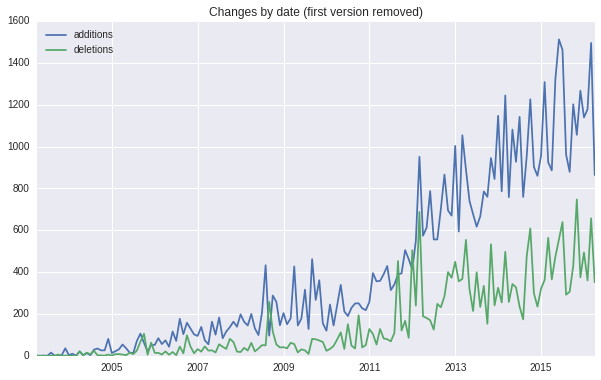

In [190]:
additions = df_by_item[df_by_item['added_after'] > pandas.Timedelta(0)][['added_in']].dropna()
additions = additions.set_index('added_in').assign(additions=1).resample('1M').count()

deletions = df_by_item[['deleted_in']].dropna()
deletions = deletions.set_index('deleted_in').assign(deletions=1).resample('1M').count()

df = additions.join(deletions, how='outer').fillna(0)
#df['difference'] = df['additions'] - df['deletions']
df.plot(title='Changes by date (first version removed)')

## Changes by ages

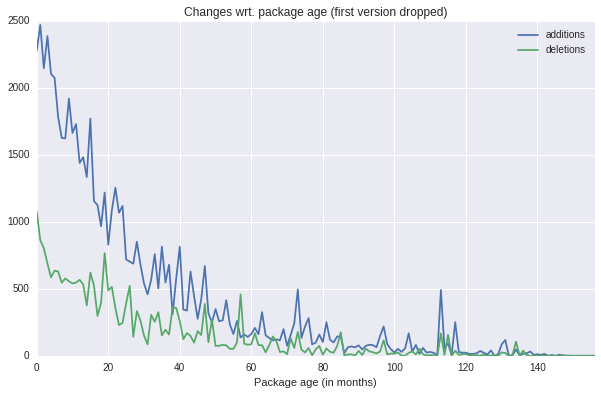

In [191]:
additions = df_by_item[df_by_item['added_after'] > pandas.Timedelta(0)][['added_after']].dropna()
additions = additions.set_index('added_after').assign(additions=1).resample('30D').count()

deletions = df_by_item[['deleted_after']].dropna()
deletions = deletions.set_index('deleted_after').assign(deletions=1).resample('30D').count()

df = additions.join(deletions, how='outer').fillna(0)
df.index = df.index.days // 30
ax = df.plot(title='Changes wrt. package age (first version dropped)')
ax.set_xlabel('Package age (in months)')

# API changes correlation

## For packages

(0, 500)

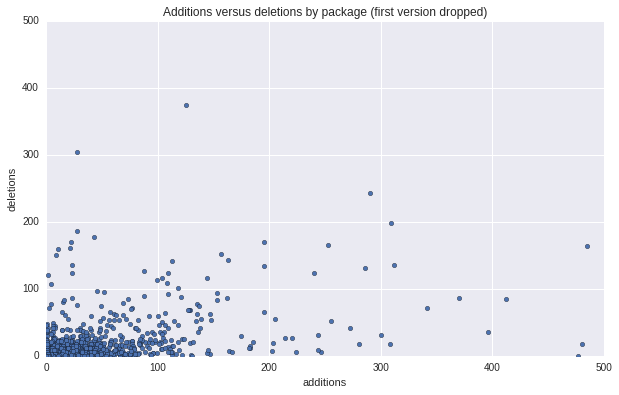

In [192]:
ax = (df_by_version
  .query('additions != items')
  .groupby(level=[0])
  .agg({'items': pandas.np.max, 'additions': pandas.np.sum, 'deletions': pandas.np.sum})
  .plot.scatter(x='additions', y='deletions', title='Additions versus deletions by package (first version dropped)'))
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)

(0, 500)

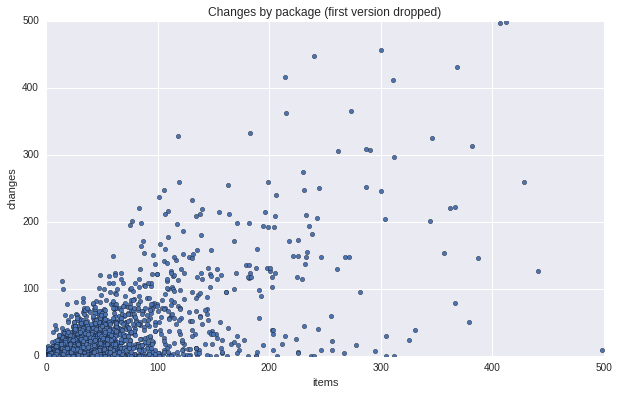

In [193]:
ax = (df_by_version
  .query('additions != items')
  .assign(changes=lambda d: d['additions'] + d['deletions'])      
  .groupby(level=[0])
  .agg({'items': pandas.np.max, 'changes': pandas.np.sum})
  .plot.scatter(x='items', y='changes', title='Changes by package (first version dropped)'))
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)

## For versions

(0, 150)

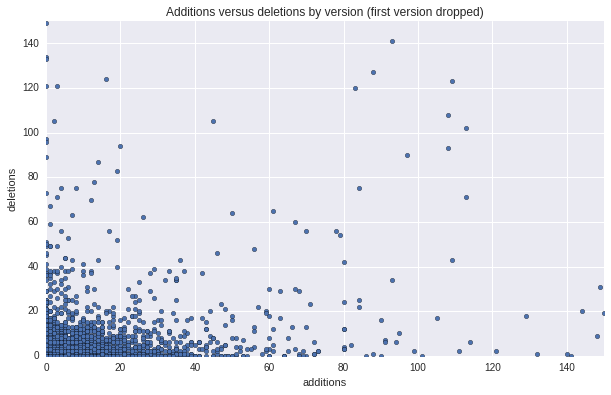

In [194]:
ax = (df_by_version
  .query('additions != items')
  .groupby(level=[0,1])
  .agg({'items': pandas.np.max, 'additions': pandas.np.sum, 'deletions': pandas.np.sum})
  .plot.scatter(x='additions', y='deletions', title='Additions versus deletions by version (first version dropped)'))
ax.set_xlim(0, 150)
ax.set_ylim(0, 150)

(0, 500)

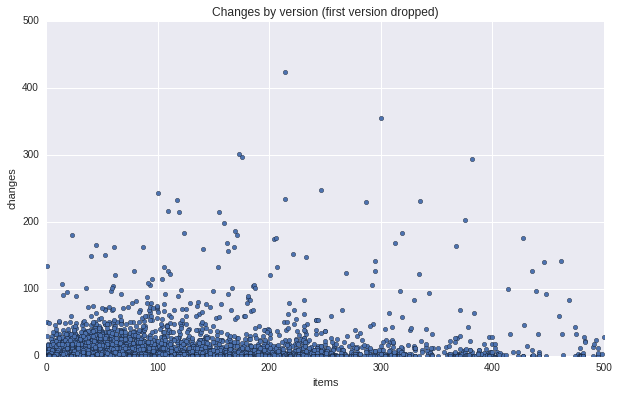

In [195]:
ax = (df_by_version
  .query('additions != items')
  .assign(changes=lambda d: d['additions'] + d['deletions'])      
  .groupby(level=[0,1])
  .agg({'items': pandas.np.max, 'changes': pandas.np.sum})
  .plot.scatter(x='items', y='changes', title='Changes by version (first version dropped)'))
ax.set_xlim(0, 500)
ax.set_ylim(0, 500)

# Survival analysis

## Time to introduce a new item

(0, 156.0)

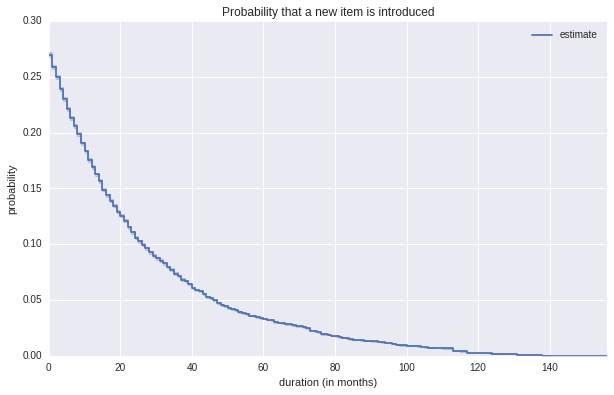

In [230]:
df = df_by_item.copy()
df['duration'] = df['added_after'].dt.days // 30

kmf = lifelines.KaplanMeierFitter()
kmf.fit(df['duration'], label='estimate')
ax = kmf.plot(title='Probability that a new item is introduced')

ax.set_xlabel('duration (in months)')
ax.set_ylabel('probability')
ax.set_xlim(left=0)

## Time to delete an introduced item

In [222]:
df = df_by_item.copy()
df['deleted'] = ~df['deleted_in'].isnull()
df['deleted_in'] = pandas.to_datetime(df['deleted_in']).where(pandas.notnull, pandas.datetime.today())
df['duration'] = (df['deleted_in'] - df['added_in']).dt.days // 30

(0, 162.0)

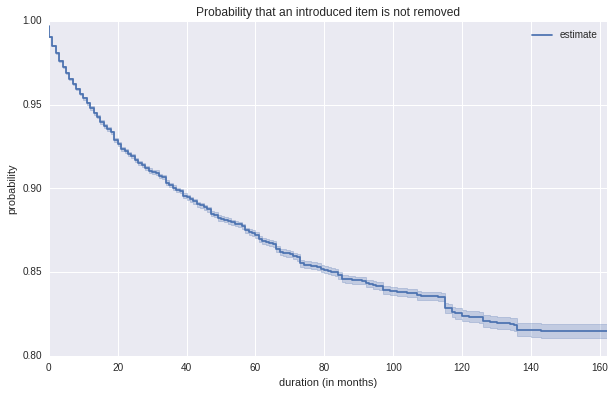

In [228]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(df['duration'], event_observed=df['deleted'], label='estimate')
ax = kmf.plot(title='Probability that an introduced item is not removed')

ax.set_xlabel('duration (in months)')
ax.set_ylabel('probability')
ax.set_xlim(left=0)